<a href="https://colab.research.google.com/github/AliMahdavifar/Mini_batch_GD/blob/main/Project_4_Ali_Mahdavifar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4, APS1070 Fall 2020
#### **Linear Regression**

*   Your **name**: **Ali Mahdavifar**


## Part 1 - Getting Started [1 mark]

In Parts 1- 6 of this project, we are designing a controller to manage the ailerons of an F16 Aircraft! 

![Ailerons](https://raw.githubusercontent.com/aps1070-2019/datasets/master/img/airplane.gif) [Ref](https://www.grc.nasa.gov/www/k-12/BGA/Mike/airplane_parts_act.htm) 


The features describe the airplane's status, and our goal is to predict the `Goal` column, which is a command that our controller should issue. We will make our predictions by implementing linear regression without regularization.

In [ ]:
# import libraries
import time
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.linalg import inv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [ ]:
# import data
df=pd.read_csv("https://raw.githubusercontent.com/aps1070-2019/datasets/master/F16L.csv" , skipinitialspace=True)

1. Print the dataframe.
2. Prepare your dataset as follows: **[1]**
*   Split the dataset into training and validation sets (80% training, 20% validation). When splitting, set `random_state=1`.
*   Standardize the data using StandardScaler from sklearn.
*   Insert a first column of 1s in both the training and validation data sets.


In [ ]:
# print dataframe
df

,inputs ClimbRate,Sgz,P,Q,CurPitch,CurRoll,AbsRoll,DiffClb,DiffRollRate,DiffDiffClb,SeTime1,SeTime2,SeTime3,SeTime4,SeTime5,SeTime6,SeTime7,SeTime8,SeTime9,SeTime10,SeTime11,SeTime12,SeTime13,SeTime14,DiffSeTime1,DiffSeTime2,DiffSeTime3,DiffSeTime4,DiffSeTime5,DiffSeTime6,DiffSeTime7,DiffSeTime8,DiffSeTime9,DiffSeTime10,DiffSeTime11,DiffSeTime12,DiffSeTime13,DiffSeTime14,Alpha,Se,Goal
0,-17,-6,-0.03,0.14,0.59,-0.5,-11,-9,0.015,-0.2,0.019,0.019,0.019,0.020,0.020,0.020,0.020,0.021,0.021,0.021,0.021,0.021,0.021,0.021,0.000,0.0,-0.002,0.0,0.0,0.0,-0.002,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.6,0.021,-0.0008
1,-791,15,-0.28,-0.34,1.11,0.9,-10,27,-0.002,4.7,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.4,0.013,-0.0009
2,-46,48,-0.42,0.07,0.57,0.6,-5,-8,-0.008,0.0,0.018,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,-0.002,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.5,0.019,-0.0005
3,496,-5,-0.21,-0.04,0.03,-0.5,-7,6,-0.002,-0.1,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.018,0.018,0.017,-0.001,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.001,0.0,0.001,0.0,0.5,0.017,-0.0005
4,-124,16,-0.02,0.05,0.61,-0.2,-9,-3,0.000,0.0,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.5,0.018,-0.0006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13745,-53,-13,-0.07,0.02,0.58,-2.3,-15,12,0.022,-0.8,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000,0.0,-0.001,0.0,0.5,0.019,-0.0007
13746,1,4,-0.11,-0.07,0.47,0.8,-5,8,-0.003,-0.2,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.5,0.016,-0.0004
13747,425,-14,0.40,0.07,0.41,-2.1,-16,12,0.031,-0.7,0.035,0.035,0.035,0.035,0.035,0.035,0.035,0.035,0.035,0.034,0.034,0.034,0.034,0.032,0.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.001,0.0,0.000,0.0,0.001,0.0,0.9,0.032,-0.0015
13748,102,-10,-0.19,0.08,1.30,0.5,-10,-3,-0.003,-0.2,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.0,1.4,0.051,-0.0015


In [ ]:
# split the dataset
y_true = df.iloc[:,-1]
X = df.iloc[:,0:-1]
X_train, X_test, y_train, y_test = train_test_split(X, y_true, \
                                        test_size = 0.2, random_state = 1)

# standardize the dataset
scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.fit_transform(X_test)

# add a column of ones to training and validation datasets
arr = np.ones((1,X_train.shape[0]), dtype=int).T
X_train =  np.append(arr, X_train, axis = 1)

arr = np.ones((1,X_test.shape[0]), dtype=int).T
X_test =  np.append(arr, X_test, axis = 1)

## Part 2 - Linear Regression - Direct Solution [2 marks]

Implement the direct solution to linear regression on the training set. **[1]**

Report the root-mean-square error (RMSE) for both the training and validation sets.**[1]**

In [ ]:
def rmse(yPred, y):
    return np.sqrt(mean_squared_error(yPred, y))

In [ ]:
# analytical solution on trainning set
W_train = np.dot(inv(np.dot(X_train.T, X_train)), np.dot(X_train.T, y_train))
# prediction
yPred_train = np.dot(X_train, W_train)
yPred_test = np.dot(X_test, W_train)

In [ ]:
print('RMSE Training: ', rmse(yPred_train, y_train))
print('RMSE Validation: ', rmse(yPred_test, y_test))

RMSE Training:  0.0001983241902503662
RMSE Validation:  0.00018782689688354653


## Part 3 - Full Batch Gradient Descent [2 marks]

We will now implement a full batch gradient descent algorithm and record the training time for our model.

1. Implement gradient descent for linear regression using a fixed learning rate of $\alpha= 1e-2$, and by iterating until your model's validation RMSE converges. Here we will consider it converged once validation RMSE is within 0.1% of the Direct Solution RMSE (i.e., $RMSE_{GD} <= RMSE_{Direct Solution}*1.001$). We call this value **Convergence threshold ($CT = RMSE_{Direct Solution}*1.001$)** and will use this value in the next parts too.

  *  Record the training time (from the first iteration until convergence) using the `time.time()` function. Be sure to compute the gradients yourself! Take a look at the code provided in the tutorial.**[0.5]**

  * Plot the Training RMSE and the Validation RMSE vs epoch on the same figure. Epoch is the number of passes on the full training set - for full batch gradient descent, it's the same as the # of gradient updates (iterations). **[0.5]**

2. Comment on overfitting/underfitting - is running the algorithm too long a concern here? **[1]**



> Answer: **The model slightly underfits at around the 100th to 300th epochs by having a lower RMSE value than the validation set. By having more epochs this is fixed and the two RMSE's asymptotically converge to the same values. The algortihm can potentially run very long for our CT value. This is becasue we are performing a full-batch gradient descent on our dataset. However, by comparing the CT of the validation set with the RMSE of the training set at each epoch, we can see that the algorithm can be stopped at around the 500th epoch.**




In [ ]:
y_train = np.array(y_train).reshape (-1,1)
CT = rmse(yPred_test, y_test)*1.001

start_time = time.time() # start timing
w = (np.random.random(X_train.shape[1])).reshape(1,-1) # Inital weights
lr = 1e-2  # Learning rate
rmse_array = []
rmse_valid_array = []

for epoch in range (0, 3000): 
  y = np.dot(X_train,w.T).reshape (-1,1)
  y_valid = np.dot(X_test,w.T).reshape (-1,1)

  rmse_gd = rmse(y,y_train)
  rmse_valid = rmse(y_valid,y_test)

  rmse_array.append(rmse_gd)
  rmse_valid_array.append(rmse_valid)
  gradient = (1/len(y) * np.dot(X_train.T, y-y_train)).reshape(1,-1)
  w = w - lr * gradient # weight update

  if rmse_gd <= CT:
    break;


print("--- Total Training Time: %s (s) ---" % (time.time() - start_time))

--- Total Training Time: 3.689004898071289 (s) ---


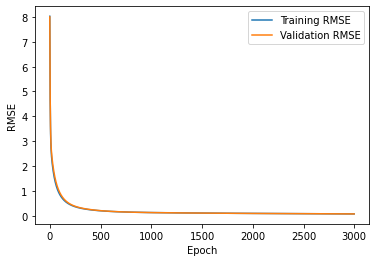

In [ ]:
plt.figure()
plt.plot(rmse_array, label = 'Training RMSE')
plt.plot(rmse_valid_array, label = 'Validation RMSE')

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.show()

## Part 4 - Mini-batch and Stochastic Gradient Descent [4 marks]

Write a function that performs mini-batch gradient descent until the convergence threshold (CT) is reached.**[1]** The inputs of that function are 
  * Training Data
  * Validation Data
  * Batch size
  * Learning Rate
  * Convergence Threshold (CT)
  * Maximum Iterations = 20000

Your function will return the following arrays: 
 * The final weights after training.
 * The training RMSE at each epoch (the number of epochs is the number of passes on the full data set).
 * The validation RMSE at each epoch.
 * An array that has the elapsed time from the start of the training process to the end of each epoch (e.g., if each epoch takes exactly 2 seconds the array would look like: [2 4 6 8 ...]).
 * For certain batchsizes GD might not converge to a solution. For that reason we have a parameter "Maximum iterations" where we limit the total number of iterations that this function can perform. 

Let's now use the function to investigate the effect of batch size on convergence. When the batch size is 1, we call that stochastic gradient descent. When the batch size equals the # of training data, it is full-batch (ie all data points are used at every iteration). Anywhere in between is mini-batch (we use some of the data).
  * Sweep different values for the mini-batch size (at least 10 values, including 1 -- Stochastic GD), each time using a learning rate of $\alpha= 1e-2$. **Hint: Try batch sizes that are powers of two (e.g., 2,4,8,16,32,...).** These batchsizes fit better on the hardware and may achieve higher performance.  **[0.5]**
  * Plot training and validation RMSE vs. **epoch** for all the batchsizes in a figure. The X-axis is Epoch # and the Y-axis is RMSE. **[0.5]**
  * Plot training and validation RMSE vs. **time** for all the batchsizes in a figure. The X-axis is Time and the Y-axis is RMSE. **[0.5]**
  * Plot Total training time (y-axis) vs. Batch size (x-axis). **[0.5]**
  * Describe your findings, including the main takeawyas from each of your plots. **[1]**

**ANSWER:**

> **RMSE vs. epoch plot: it seems that there is a certain threshold where the min-batch acheives the lowest RMSE; this means by increasing the batch size we dont necessarily get the best RMSE. Due to the randomness incorporated in forming my mini batches, this threshold changes.**



> **RMSE vs. time plot: understandably, the stochastic GD is going to take a longer time than the mini batch method mainly because it takes steps in a noisy direction, making it less efficient that the mini-batch method. As we increase the batch size, the computation time decreases. Computation time for batch size 256 and 512 is very similar.**



> **Total time vs. batch size plot: this plot confirms the findings for the previous plot. There is a significant drop in computation time for small batch sizes compared to the stochastic GD.**




In [ ]:
def miniBatch(X_train, y_train, X_test, y_test, batch_size, lr, \
             CT, max_iter):
  converged = False
  y_train = np.array(y_train).reshape (-1,1)

  w = (np.random.random(X_train.shape[1])).reshape(1,-1) # Inital weights

  m = len(y_train)
  rmse_array = []
  rmse_valid_array = []
  time_array = []
  epoch = 1

  start_time = time.time() # start timing
  while not converged: 
    indices = np.random.permutation(m)
    X = X_train[indices, :]
    y = y_train[indices]

    rmse_gd = 0.0
    rmse_valid = 0.0

    for i in range (0, m, batch_size):
      X_i = X[i:i+batch_size]
      y_i = y[i:i+batch_size]

      yPred = np.dot(X_i,w.T).reshape(-1,1)
      gradient = (1/len(y) * np.dot(X_i.T, yPred-y_i)).reshape(1,-1)
      w = w - lr * gradient # weight update

    yPred = np.dot(X_train,w.T).reshape(-1,1)
    y_valid = np.dot(X_test,w.T).reshape(-1,1)

    rmse_valid = rmse(y_valid,y_test)
    rmse_gd = rmse(yPred,y_train)

    rmse_array.append(rmse_gd)
    rmse_valid_array.append(rmse_valid)

    time_array.append(time.time() - start_time) # record timing for one epoch

    if rmse_gd <= CT:
      converged = True
    if epoch == max_iter:
      break

    epoch += 1

  return w, rmse_array, rmse_valid_array, time_array, epoch

In [ ]:
# perform mini-batch gradient descent for multiple batch sizes
batch_sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
CT = rmse(yPred_test, y_test)*1.001
lr = 1e-2
max_iter = 100

y_train = np.array(y_train).reshape (-1,1)
y_test = np.array(y_test).reshape (-1,1)

rmse_arrays = np.zeros([len(batch_sizes),max_iter])
rmse_valid_arrays = np.zeros([len(batch_sizes),max_iter])
time_arrays = np.zeros([len(batch_sizes),max_iter])

for i in range(len(batch_sizes)):
  w, rmse_arrays[i,:], rmse_valid_arrays[i,:], time_arrays[i,:], epoch = \
   miniBatch(X_train, y_train, X_test, y_test, batch_sizes[i], lr, CT, max_iter)


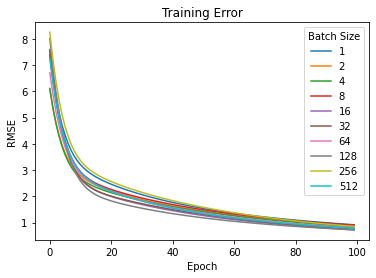

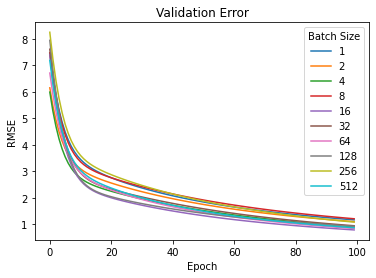

In [ ]:
# plot training data vs. epoch:
fig, axs = plt.subplots()
for i in range(len(batch_sizes)):
  axs.plot(rmse_arrays[i,:], label = "%i" %(batch_sizes[i]))

plt.legend(title = 'Batch Size')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title('Training Error')
plt.show()

# plot validation data vs. epoch:
fig, axs = plt.subplots()
for i in range(len(batch_sizes)):
  axs.plot(rmse_valid_arrays[i,:], label = "%i" %(batch_sizes[i]))

plt.legend(title = 'Batch Size')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title('Validation Error')
plt.show()

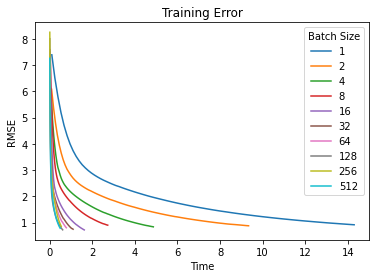

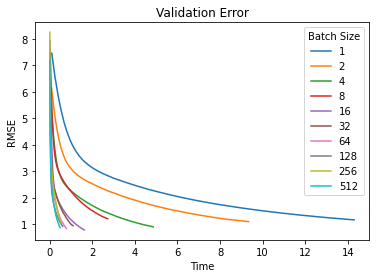

In [ ]:
# plot training data vs. time:
fig, axs = plt.subplots()
for i in range(len(batch_sizes)):
  axs.plot(time_arrays[i,:], rmse_arrays[i,:], label = "%i" %(batch_sizes[i]))

plt.legend(title = 'Batch Size')
plt.xlabel("Time")
plt.ylabel("RMSE")
plt.title('Training Error')
plt.show()

# plot validation data vs. time:
fig, axs = plt.subplots()
for i in range(len(batch_sizes)):
  axs.plot(time_arrays[i,:], rmse_valid_arrays[i,:], label = "%i" %(batch_sizes[i]))

plt.legend(title = 'Batch Size')
plt.xlabel("Time")
plt.ylabel("RMSE")
plt.title('Validation Error')
plt.show()

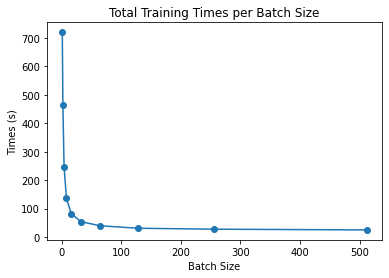

In [ ]:
# plot total training time vs. batch size
total_time = np.sum(time_arrays, axis=1).reshape(-1, 1)
plt.plot(batch_sizes, total_time, '-o')

plt.xlabel("Batch Size")
plt.ylabel("Times (s)")
plt.title('Total Training Times per Batch Size')
plt.show()

## Part 5 - Gradient Descent Learning Rate [2 marks]
Use the function that you designed in Part 4 to investigate the effect of learning rate on convergence.

Select the best batch size based on the fastest convergence time and sweep the learning rate (at least 10 values) while applying Mini-batch GD. 
  1. Plot the training and validation RMSE vs **epoch** (x-axis) for all the learning rates that you tried in a figure. **[0.5]**
  2. Plot the training and validation RMSE vs **time** (x-axis) for all the learning rates that you tried in a figure. **[0.5]**
  3. Describe your findings, including the main takeawyas from each of your plots. **[1]**

  **ANSWER:**


> **The error blows up for learning rates 3.0 and 5.0, although they do at different orders of magnitude. On the other hand, the rate of decrease of error for the fine leanring rate of 0.001 goes to show that the rate is very slow and inefficent in convergence. From both graphs, it seems that a learning rate of 1.0 yields the fastest convergance rate. Both types of graphs show similar behaviour for each corresponding learning rate.**




In [ ]:
# perform min-batch GD for various learning rates
lr_array = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 3.0, 5.0]
# lr_array = [5.0]

batch_size = 256
CT = rmse(yPred_test, y_test)*1.001
lr = 1e-2
max_iter = 100

y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)

rmse_arrays = np.zeros([len(lr_array),max_iter])
rmse_valid_arrays = np.zeros([len(lr_array),max_iter])
time_arrays = np.zeros([len(lr_array),max_iter])

for i in range(len(lr_array)):
  w, rmse_arrays[i,:], rmse_valid_arrays[i,:], time_arrays[i,:], epoch = \
   miniBatch(X_train, y_train, X_test, y_test, batch_size, lr_array[i], CT, max_iter)

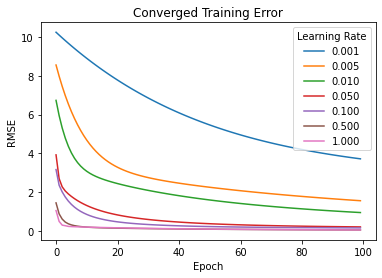

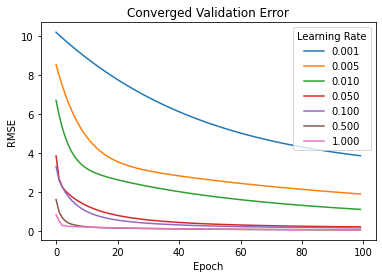

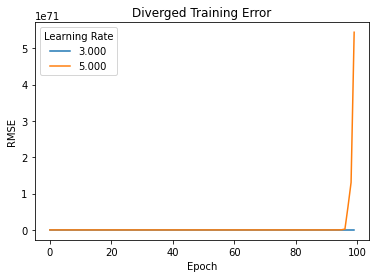

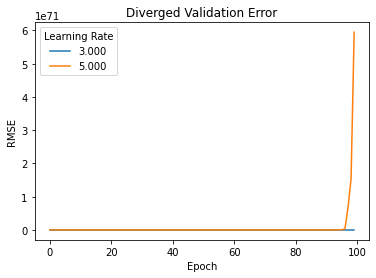

In [ ]:
# plot training data vs. epoch (converged):
fig, axs = plt.subplots()
for i in range(len(lr_array)-2):
  axs.plot(rmse_arrays[i,:], label = "%.3f" %(lr_array[i]))

plt.legend(title = 'Learning Rate')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title('Converged Training Error')
plt.show()

# plot validation data vs. epoch (converged):
fig, axs = plt.subplots()
for i in range(len(batch_sizes)-3):
  axs.plot(rmse_valid_arrays[i,:], label = "%.3f" %(lr_array[i]))

plt.legend(title = 'Learning Rate')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title('Converged Validation Error')
plt.show()

#############

# plot training data vs. epoch (divereged):
fig, axs = plt.subplots()
for i in range(len(lr_array)-2, len(lr_array)):
  axs.plot(rmse_arrays[i,:], label = "%.3f" %(lr_array[i]))

plt.legend(title = 'Learning Rate')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title('Diverged Training Error')
plt.show()

# plot validation data vs. epoch (divereged):
fig, axs = plt.subplots()
for i in range(len(batch_sizes)-3, len(lr_array)):
  axs.plot(rmse_valid_arrays[i,:], label = "%.3f" %(lr_array[i]))

plt.legend(title = 'Learning Rate')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title('Diverged Validation Error')
plt.show()

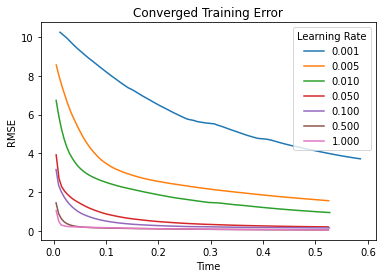

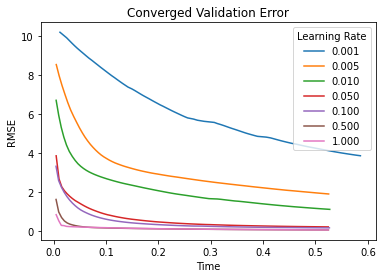

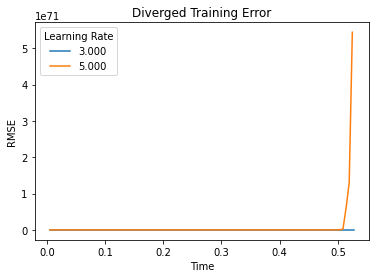

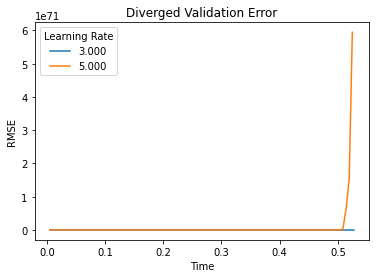

In [ ]:
# plot training data vs. time (converged):
fig, axs = plt.subplots()
for i in range(len(lr_array)-2):
  axs.plot(time_arrays[i,:], rmse_arrays[i,:], label = "%.3f" %(lr_array[i]))

plt.legend(title = 'Learning Rate')
plt.xlabel("Time")
plt.ylabel("RMSE")
plt.title('Converged Training Error')
plt.show()

# plot validation data vs. time (converged):
fig, axs = plt.subplots()
for i in range(len(batch_sizes)-3):
  axs.plot(time_arrays[i,:], rmse_valid_arrays[i,:], label = "%.3f" %(lr_array[i]))

plt.legend(title = 'Learning Rate')
plt.xlabel("Time")
plt.ylabel("RMSE")
plt.title('Converged Validation Error')
plt.show()

#############

# plot training data vs. time (divereged):
fig, axs = plt.subplots()
for i in range(len(lr_array)-2, len(lr_array)):
  axs.plot(time_arrays[i,:], rmse_arrays[i,:], label = "%.3f" %(lr_array[i]))

plt.legend(title = 'Learning Rate')
plt.xlabel("Time")
plt.ylabel("RMSE")
plt.title('Diverged Training Error')
plt.show()

# plot validation data vs. time (divereged):
fig, axs = plt.subplots()
for i in range(len(batch_sizes)-3, len(lr_array)):
  axs.plot(time_arrays[i,:], rmse_valid_arrays[i,:], label = "%.3f" %(lr_array[i]))

plt.legend(title = 'Learning Rate')
plt.xlabel("Time")
plt.ylabel("RMSE")
plt.title('Diverged Validation Error')
plt.show()


## Part 6 - Gradient Descent with Adaptive Learning Rate [4 marks]
Implement an adaptive learning rate scheme where you start a mini-batch gradient descent with a large learning rate and decrease the learning rate while you are getting closer to the local minima. It's up to you to come up with a way to set **when** and **how much** do you want to change the learning rate. 
Our goal is to find a method for faster convergence. 
  1. Describe **[1]** and implement **[1]** your method.
**ANSWER:**

> **We implement a step decay schedule for the learning rate, where we start with an initial rate for the first epoch and drop the rate by a factor for every 10 epochs. The formula is as follows:**

```
lr = lr0 * drop^floor(epoch / epochs_drop)
```

Source: [here](https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1)


  2. Plot the training and validation RMSE vs **epoch** for your method (adaptive learning rate), alongside your best training run from Part 5 (static learning rate). **[1]**
  3. Plot the training and validation RMSE vs **time** for your method (adaptive learning rate), alongside your best training run from Part 5 (static learning rate). **[1]**

In [ ]:
def step_decay(epoch):
  initial_lr = 0.1
  drop = 0.5
  epochs_drop = 10.0
  lr = initial_lr* math.pow(drop, math.floor((1+epoch)/epochs_drop))
  return lr

In [ ]:
def adaptiveMiniBatch(X_train, y_train, X_test, y_test, batch_size, \
             CT, max_iter):
  converged = False
  y_train = np.array(y_train).reshape (-1,1)

  w = (np.random.random(X_train.shape[1])).reshape(1,-1) # Inital weights

  m = len(y_train)
  rmse_array = []
  rmse_valid_array = []
  time_array = []
  epoch = 1

  start_time = time.time() # start timing
  while not converged:
    lr = step_decay(epoch) # adaptive learning rate

    indices = np.random.permutation(m)
    X = X_train[indices, :]
    y = y_train[indices]

    rmse_gd = 0.0
    rmse_valid = 0.0

    for i in range (0, m, batch_size):
      X_i = X[i:i+batch_size]
      y_i = y[i:i+batch_size]

      yPred = np.dot(X_i,w.T).reshape(-1,1)
      gradient = (1/len(y) * np.dot(X_i.T, yPred-y_i)).reshape(1,-1)
      w = w - lr * gradient # weight update

    yPred = np.dot(X_train,w.T).reshape(-1,1)
    y_valid = np.dot(X_test,w.T).reshape(-1,1)

    rmse_valid = rmse(y_valid,y_test)
    rmse_gd = rmse(yPred,y_train)

    rmse_array.append(rmse_gd)
    rmse_valid_array.append(rmse_valid)

    time_array.append(time.time() - start_time) # record timing for one epoch

    if rmse_gd <= CT:
      converged = True
    if epoch == max_iter:
      break

    epoch += 1

  return w, rmse_array, rmse_valid_array, time_array, epoch, lr

In [ ]:
# perfrom mini-batch GD with adaptive learning rate
batch_size = 256
CT = rmse(yPred_test, y_test)*1.001
max_iter = 1000

y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)

w_adpt, rmse_array_adpt, rmse_valid_arrays_adpt, time_arrays_adpt, epoch_adpt, lr = \
  adaptiveMiniBatch(X_train, y_train, X_test, y_test, batch_size, CT, max_iter)

# perform min-batch GD with static learning rate
batch_size = 256
CT = rmse(yPred_test, y_test)*1.001
max_iter = 1000
alpha = 0.01

y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)

w, rmse_array, rmse_valid_array, time_array, epoch = \
  miniBatch(X_train, y_train, X_test, y_test, batch_size, alpha, CT, max_iter)


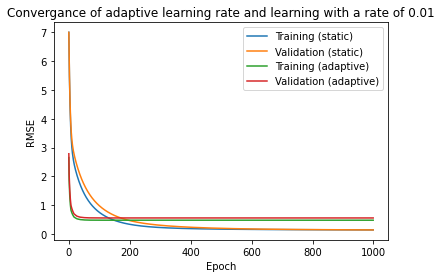

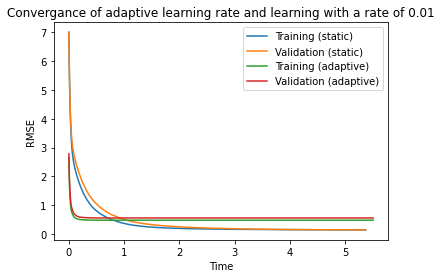

In [ ]:
# plot training and validation data vs. epoch (adaptive):
fig, axs = plt.subplots()

axs.plot(rmse_array, label = 'Training (static)')
axs.plot(rmse_valid_array, label = 'Validation (static)')
axs.plot(rmse_array_adpt, label = 'Training (adaptive)')
axs.plot(rmse_valid_arrays_adpt, label = 'Validation (adaptive)')

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title('Convergance of adaptive learning rate and learning with a rate of 0.01')
plt.show()

# plot training and validation data vs. time (adaptive):
fig, axs = plt.subplots()

axs.plot(time_array, rmse_array, label = 'Training (static)')
axs.plot(time_array, rmse_valid_array, label = 'Validation (static)')
axs.plot(time_arrays_adpt, rmse_array_adpt, label = 'Training (adaptive)')
axs.plot(time_arrays_adpt, rmse_valid_arrays_adpt, label = 'Validation (adaptive)')

plt.legend()
plt.xlabel("Time")
plt.ylabel("RMSE")
plt.title('Convergance of adaptive learning rate and learning with a rate of 0.01')
plt.show()


## Part 7 - Gradient Descent with Additional Features and Regularization [3 marks]

Now, we'll apply linear regresssion to a toy dataset (`LR_data.csv`), with 10 features `x1`-`x10` and a "measurement" `y`. We'll take a few shortcuts by using built-in sklearn functions.

1. Data Preparation **[0.5]**
  * Print the dataset, and create Numpy arrays with inputs (X) and outputs (y). 
  * Split the dataset into training and validation sets (80% training, 20% validation). When splitting, set `random_state=1`.

2. Linear Regression **[0.5]**
  * Standardize the data using StandardScaler from sklearn.
  * Use the `sklearn.linear_model.LinearRegression` function [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) to perform linear regression.
  * Print the RMSE for training and validation data.

3. Linear Regression with Additional Features **[0.5]**
  * Let's add more features to our dataset (up to degree 8) using `sklearn.preprocessing.PolynomialFeatures` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html). You'll want to create the additional features first, then perform standardization (start from non-standardized data).
  * Again, use `sklearn.linear_model.LinearRegression` to perform linear regression.
  * Print the RMSE for training and validation data.

4. Linear Regression with Additional Features and Regularization **[0.5]**
  * Let's switch models, and instead use the `sklearn.linear_model.Ridge` function [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) to perform linear regression with regularization. Apply the model to the processed data (additional, standardized) you used in 3 above. Use a `FOR` loop to run `sklearn.linear_model.Ridge` with different `alpha` values. Specifically, sweep `alpha` from 1E-2 to 1E10 (each step is an order of magnitude jump).

5. Discuss your results. What do you conclude? **[1]**

**ANSWER:**

> **By looking at the plot below and how the test error behaves over a set of regularization parameters, we can see that there is an optimal value for this parameter and that is:**

```
alpha = 1e4
```



> **Alpha serves as the regularization strength which immproves the conditionaing of the problem and reduces variance of the estimates. However, increasing this hyperparameter to an excessive value will result in a sub-optimal and less efficient solution, as it can be seen for both training and test errors for values over 1e4.**







In [ ]:
import pandas as pd
df=pd.read_csv("https://www.eecg.utoronto.ca/~hadizade/APS1070/LR_data.csv" , skipinitialspace=True)

In [ ]:
# 1.1 print the dataset
df

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,1.454481,4.940543,7.116015,3.805131,4.105432,1.832290,5.211909,5.088293,3.841250,6.121133,6.575066e+06
1,4.907182,1.653654,7.339445,9.065282,7.169233,2.354136,2.893005,8.720131,8.646473,3.806860,8.419881e+06
2,1.842804,1.183878,4.203206,6.815847,6.655899,8.295816,3.556779,5.794679,3.260723,5.463808,9.745537e+04
3,2.393457,0.094127,3.208929,0.497443,4.318127,4.999247,9.470238,3.061990,7.312995,5.475240,1.129200e+04
4,5.093724,3.905293,4.858562,4.465484,0.947091,9.410307,8.137329,9.043838,9.128607,0.790795,3.105448e+05
...,...,...,...,...,...,...,...,...,...,...,...
195,2.936450,2.094812,9.493814,3.411240,4.350940,0.386062,1.303290,2.699563,7.622569,3.037162,6.599726e+07
196,4.915597,1.953974,7.312552,9.331203,1.329366,8.286760,5.233018,7.476923,7.043560,5.745565,8.176250e+06
197,6.772096,6.406489,4.638352,7.042340,0.912338,7.568296,1.194928,2.592840,9.386478,4.147710,2.144147e+05
198,3.940339,4.330498,6.693371,9.169265,0.858846,0.601942,2.635455,2.037859,7.883720,8.525164,4.028735e+06


In [ ]:
# 1.2 split the data set
y_true = df.iloc[:,-1]
X = df.iloc[:,0:-1]
X_train_orig, X_test_orig, y_train_orig, y_test_orig = \
             train_test_split(X, y_true, test_size = 0.2, random_state = 1)
X_train_orig = np.array(X_train_orig)
X_test_orig = np.array(X_test_orig)
y_train = np.array(y_train_orig).reshape(-1,1)
y_test = np.array(y_test_orig).reshape(-1,1)


In [ ]:
# 2.1 standardize the dataset
scalar = StandardScaler()
X_train = scalar.fit_transform(X_train_orig)
X_test = scalar.fit_transform(X_test_orig)

# 2.2 perform linear regression
reg = LinearRegression().fit(X_train, y_train)

# 2.3 print RMSE for training and validation data
y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)

rmse_train = rmse(y_pred_train, y_train)
rmse_test = rmse(y_pred_test, y_test)

print('RMSE Training: ', rmse_train)
print('RMSE Validation: ', rmse_test)


RMSE Training:  16296980.655667374
RMSE Validation:  14701217.930816373


In [ ]:
# 3.1 add more feature to original datasets
poly = PolynomialFeatures(8, include_bias=False)
X_train_og = poly.fit_transform(X_train_orig)
X_test_og = poly.fit_transform(X_test_orig)

scalar = StandardScaler()
X_train_std = scalar.fit_transform(X_train_og)
X_test_std = scalar.fit_transform(X_test_og)

# 3.2 perform linear regression
reg = LinearRegression().fit(X_train_std, y_train)

# 3.3 print RMSE for training and validation data
y_pred_train = reg.predict(X_train_std)
y_pred_test = reg.predict(X_test_std)

rmse_train = rmse(y_pred_train, y_train)
rmse_test = rmse(y_pred_test, y_test)

print('RMSE Training: ', rmse_train)
print('RMSE Validation: ', rmse_test)

RMSE Training:  7.514772862591428e-08
RMSE Validation:  11865101.742165675


In [ ]:
# 4.1 perform linear regression with regularization
alphas=[]
alphas = [math.pow(10,(i)) for i in range(-2,11)]

rmse_train_array = []
rmse_test_array = []

for i in range(len(alphas)):
  clf = Ridge(alpha=alphas[i])
  reg = clf.fit(X_train_std, y_train)

  y_pred_train = reg.predict(X_train_std)
  y_pred_test = reg.predict(X_test_std)

  rmse_train = rmse(y_pred_train, y_train)
  rmse_test = rmse(y_pred_test, y_test)

  rmse_train_array.append(rmse_train)
  rmse_test_array.append(rmse_test)

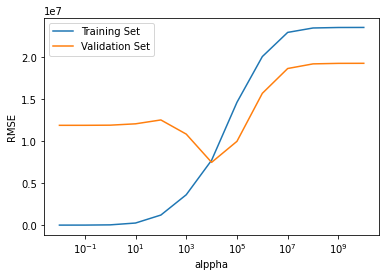

In [ ]:
# 4.2 print the results
fig, axs = plt.subplots()

axs.plot(alphas, rmse_train_array, label = 'Training Set')
axs.plot(alphas, rmse_test_array, label = 'Validation Set')

axs.set_xscale('log')

plt.legend()
plt.xlabel("alppha")
plt.ylabel("RMSE")
plt.show()

## Part 8 - Linear Regression with a Custom Dataset [2 marks]


Find a dataset online and train and validate a linear regression model with the techniques you learned in this Project.

*   Introduce your dataset.**[0.5]**


> **ANSWER: The dataset is retreived from kaggle ([here](https://www.kaggle.com/harlfoxem/housesalesprediction)), and contains house sale prices for King County. We would like to predict housing prices based on the given features of the sample points.**

*   Explain your approach. **[0.5]**

> **ANSWER: we implement two methods of GD with regularization as in part 7.4 and linear regression as in part 7.2.**

*   Summarize your results. **[1]**

> **ANSWER: For the GD method with regularization, we see that the optimal hyperparameter is, in fact, the set 1e-2 to 1e2, which yield very similar results for both training and test errors. This optmial error values is also achieved by the linear regression method confirming that they both have arrived at the same local minima for this problem.**

Hint: you can find various datasets in here: https://www.kaggle.com/datasets.

To use a dataset in Colab, you can upload it in your Google drive and access it in Colab ([help here](https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a)), or you can download the dataset on your local machine and upload it directly to Colab using the following script.

```
from google.colab import files
uploaded = files.upload()
```

When submitting your project on Quercus, Please make sure you are also uploading your dataset so we can fully run your notebook.






In [ ]:
df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [ ]:
# split the dataset
X_cols = [
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

target = ['price']

X = df[X_cols]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

# organize the split data into sets
train_set = X_train.copy(deep=True)
train_set['price']= y_train

test_set = X_test.copy(deep=True)
test_set['price']= y_test

In [ ]:
# standardize the data
scaler = StandardScaler()
scaler.fit(train_set)

train_set_scaled = scaler.transform(train_set)
test_set_scaled = scaler.transform(test_set)

train_set_scaled_df = pd.DataFrame(train_set_scaled, index=train_set.index, columns=train_set.columns)
test_set_scaled_df = pd.DataFrame(test_set_scaled, index=test_set.index, columns=test_set.columns)

X_train_scaled_df = train_set_scaled_df[X_cols]
y_train_scaled_df = train_set_scaled_df[target]

X_test_scaled_df = test_set_scaled_df[X_cols]
y_test_scaled_df = test_set_scaled_df[target]

X_train_std = np.array(X_train_scaled_df)
y_train_std = np.array(y_train_scaled_df)

X_test_std = np.array(X_test_scaled_df)
y_test_std = np.array(y_test_scaled_df)

In [ ]:
# method 1: perform linear regression with regularization
alphas=[]
alphas = [math.pow(10,(i)) for i in range(-2,11)]

rmse_train_array = []
rmse_test_array = []

for i in range(len(alphas)):
  clf = Ridge(alpha=alphas[i])
  reg = clf.fit(X_train_std, y_train_std)

  y_pred_train = reg.predict(X_train_std)
  y_pred_test = reg.predict(X_test_std)

  rmse_train = rmse(y_pred_train, y_train_std)
  rmse_test = rmse(y_pred_test, y_test_std)

  rmse_train_array.append(rmse_train)
  rmse_test_array.append(rmse_test)

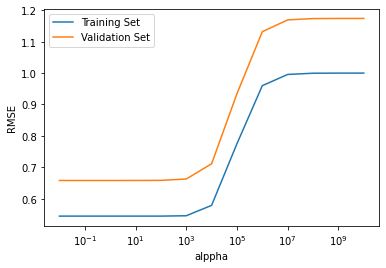

In [ ]:
# print results
fig, axs = plt.subplots()

axs.plot(alphas, rmse_train_array, label = 'Training Set')
axs.plot(alphas, rmse_test_array, label = 'Validation Set')

axs.set_xscale('log')

plt.legend()
plt.xlabel("alppha")
plt.ylabel("RMSE")
plt.show()

In [ ]:
rmse_train_array, rmse_test_array

([0.5443152531144775,
  0.5443152531297603,
  0.5443152546575966,
  0.5443154070030932,
  0.5443302161679543,
  0.5454840217289066,
  0.5785846241758912,
  0.7751026259135706,
  0.9599785225514114,
  0.9956570336107382,
  0.9995619714880102,
  0.9999561594756375,
  0.9999956155704744],
 [0.6578259156277917,
  0.6578262712800871,
  0.6578298286759033,
  0.6578654895864042,
  0.6582304704930602,
  0.6624741354721558,
  0.7110394249576422,
  0.9343462115836244,
  1.131940897392036,
  1.1695416932236962,
  1.1736494576435,
  1.174064041429577,
  1.1741055382434473])

In [ ]:
# method 2: perform linear regression
reg = LinearRegression().fit(X_train_std, y_train_std)

y_pred_train = reg.predict(X_train_std)
y_pred_test = reg.predict(X_test_std)

rmse_train = rmse(y_pred_train, y_train_std)
rmse_test = rmse(y_pred_test, y_test_std)

# print results
print('RMSE Training: ', rmse_train)
print('RMSE Validation: ', rmse_test)

RMSE Training:  0.5443152531143232
RMSE Validation:  0.6578258761118501
